<font size='12'><center>
    Unsupervised learning on bilateral trade data
</font></center>

In [1]:
! pip install -q pyreadr
! pip install -q altair

In [2]:
import pyreadr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
import altair as alt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Data wrangling

## Data acquisition

In [3]:
#! wget -qO Data/panel_results.Rdata https://zenodo.org/record/3610558/files/panel_results.Rdata?download=1

In [4]:
panel = pyreadr.read_r('Data/GER_Orig_Sect_Year_Africa.Rdata')
IFF_Sector = panel['GER_Orig_Sect_Year_Africa']

In [5]:
obs_info = IFF_Sector.reset_index().drop_duplicates(['reporter.ISO', 'year'])[['reporter.ISO', 
                                                                               'year', 
                                                                               'reporter', 
                                                                               'rIncome', 
                                                                               'rDev']]
obs_info = obs_info.replace({'LIC': 'Low income', 
                             'LMC': 'Lower-middle income',
                             'UMC': 'Upper-middle income',
                             'HIC': 'High income'})
obs_info = obs_info.rename(columns={'rIncome': 'Income group (World Bank)', 
                                    'rDev': 'Country status (UN)'})

In [6]:
IFF_Sector = IFF_Sector.fillna(0).drop(columns=['reporter', 'rIncome', 'rDev', 'section.code',
                                                'Imp_IFF_lo', 'Exp_IFF_lo']) \
            .set_index(['reporter.ISO', 'year'])

IFF_Sector_mean = IFF_Sector.reset_index().groupby(['reporter.ISO', 'section']).mean(). \
    reset_index().set_index('reporter.ISO')
IFF_Sector_log = IFF_Sector.apply(lambda x: np.log(x+1) if np.issubdtype(x.dtype, np.number) else x)

In [7]:
IFF_Sector_Imp = IFF_Sector[['section', 'Imp_IFF_hi']]
IFF_Sector_Exp = IFF_Sector[['section', 'Exp_IFF_hi']]

# PCA

## Auxiliary Functions

In [8]:
def create_features(data, values, features, obs):
    features_data = data.pivot_table(values=values, 
                                     columns=features, 
                                     index=[obs, 'year'], 
                                     fill_value=0)
    return features_data

In [9]:
def create_features_mean(data, values, features, obs):
    features_data = data.pivot_table(values=values, 
                                     columns=features, 
                                     index=obs, 
                                     fill_value=0)
    return features_data

In [10]:
def biplot_PCA(features_data, nPC=2, firstPC=1, secondPC=2, obs='reporter.ISO', show_loadings=False):
    """Projects the data in the 2-dimensional space spanned by 2 principal components
    chosen by the user, along with a bi-plot of the top 3 loadings per PC, and colors
    by class label.

    Args:
        features_data: data-set of features
        nPC: number of principal components
        firstPC: integer denoting first principal component to plot in bi-plot
        secondPC: integer denoting second principal component to plot in bi-plot
        obs: string denoting index of class labels (in features_data)
        show_loadings: Boolean indicating whether PCA loadings should be displayed
    Returns:
        plot (static)
        pca_loadings (if show_loadings=True)
    """
        
    # Run PCA (standardize beforehand)
    features_data_std = StandardScaler().fit_transform(features_data)
    pca = PCA(n_components=nPC)
    princ_comp = pca.fit_transform(features_data_std)

    # Loadings
    cols = ['PC' + str(c+1) for c in np.arange(nPC)]
    pca_loadings = pd.DataFrame(pca.components_.T, 
                                columns=cols,
                                index=list(features_data.columns))
   
    # Scores
    pca_scores = pd.DataFrame(princ_comp, 
                              columns=cols)
    pca_scores[obs] = features_data.reset_index()[obs].values.tolist()
    pca_scores['year'] = features_data.reset_index()['year'].values.tolist()
    
    score_PC1 = princ_comp[:,firstPC-1]
    score_PC2 = princ_comp[:,secondPC-1]
    
    # Plot data
    if obs == 'reporter.ISO':
        plot_data = pd.merge(pca_scores, obs_info, on=[obs, 'year'])
        color_obs = 'reporter'
        tooltip_obs = ['reporter', 'year', 'Income group (World Bank)', 'Country status (UN)']
    else:
        plot_data = pca_scores
        color_obs = 'section'
        tooltip_obs = ['section', 'year']

    # Return chosen PCs to plot
    PC1 = 'PC'+str(firstPC)
    PC2 = 'PC'+str(secondPC)

    # Top loadings (in absolute value)
    # TO DO: use dict to iterate over
    toploadings_PC1 = pca_loadings.apply(lambda x: abs(x)).sort_values(by=PC1).tail(3)[[PC1, PC2]]
    toploadings_PC2 = pca_loadings.apply(lambda x: abs(x)).sort_values(by=PC2).tail(3)[[PC1, PC2]]

    originsPC1 = pd.DataFrame({'index':toploadings_PC1.index.tolist(), 
                               PC1: np.zeros(3), 
                               PC2:np.zeros(3)})
    originsPC2 = pd.DataFrame({'index':toploadings_PC2.index.tolist(), 
                               PC1: np.zeros(3), 
                               PC2:np.zeros(3)})
    
    toploadings_PC1 = pd.concat([toploadings_PC1.reset_index(), originsPC1], axis=0)
    toploadings_PC2 = pd.concat([toploadings_PC2.reset_index(), originsPC2], axis=0)

    toploadings_PC1[PC1] = toploadings_PC1[PC1]*max(score_PC1)*1.5
    toploadings_PC1[PC2] = toploadings_PC1[PC2]*max(score_PC2)*1.5
    toploadings_PC2[PC1] = toploadings_PC2[PC1]*max(score_PC1)*1.5
    toploadings_PC2[PC2] = toploadings_PC2[PC2]*max(score_PC2)*1.5
    
    # Project top 3 loadings over the space spanned by 2 principal components
    lines = alt.Chart().mark_line().encode()
    for color, i, dataset in zip(['#440154FF', '#21908CFF'], [0,1], [toploadings_PC1, toploadings_PC2]):
        lines[i] = alt.Chart(dataset).mark_line(color=color).encode(
        x= PC1 +':Q',
        y= PC2 +':Q',
        detail='index'
    ).properties(
        width=500,
        height=500
    )
    
    # Add labels to the loadings
    text=alt.Chart().mark_text().encode()
    for color, i, dataset in zip(['#440154FF', '#21908CFF'], [0, 1], [toploadings_PC1[0:3], toploadings_PC2[0:3]]):
        text[i] = alt.Chart(dataset).mark_text(
                align='left',
                baseline='bottom',
                color=color
            ).encode(
                x= PC1 +':Q',
                y= PC2 +':Q',
                text='index'
            )
    
    # Scatter plot colored by observation class label
    points = alt.Chart(plot_data).mark_circle(size=60).encode(
        x=alt.X(PC1, axis=alt.Axis(title='Principal Component ' + str(firstPC))),
        y=alt.X(PC2, axis=alt.Axis(title='Principal Component ' + str(secondPC))),
        color=alt.Color(color_obs, scale=alt.Scale(scheme='category20b'),
                       legend=alt.Legend(orient='right')),
        tooltip=tooltip_obs
    ).interactive()
    
    chart = (points + lines[0] + lines[1] + text[0] + text[1])    
    chart.display()

    if show_loadings:
        return pca_loadings

## Sector features

In [11]:
sector_features = create_features(IFF_Sector_Imp, 'Imp_IFF_hi', 
                                  features='section', obs='reporter.ISO')
sector_features

section            Animal and Animal Products  \
reporter.ISO year                               
AGO          2009                2.694946e+08   
             2010                2.064906e+08   
             2011                2.995594e+08   
             2012                7.103770e+08   
             2013                4.031560e+08   
...                                       ...   
ZWE          2011                3.098093e+07   
             2012                2.784481e+07   
             2013                0.000000e+00   
             2014                0.000000e+00   
             2015                1.458046e+07   

section            Animal or Vegetable Fats and Oils  Arms and Ammunition  \
reporter.ISO year                                                           
AGO          2009                       7.652455e+07         67738.261242   
             2010                       7.311396e+07             0.000000   
             2011                       8.058180e+07         89365.880480   
             2012                       2.746924e+08        261265.895948   
             2013                       1.541679e+08        188343.533148   
...                                              ...                  ...   
ZWE          2011                       6.060789e+07          9124.882478   
             2012                       5.549232e+07           856.631347   
             2013                       0.000000e+00             0.000000   
             2014                       0.000000e+00             0.000000   
             2015                       7.135043e+07         19192.507302   

section             Base Metals  Chemicals and Allied Industries  \
reporter.ISO year                                                  
AGO          2009  1.025920e+09                     5.115176e+08   
             2010  9.989842e+08                     2.575443e+08   
             2011  6.689511e+08                     2.931591e+08   
             2012  1.753970e+09                     8.540407e+08   
             2013  9.230300e+08                     4.793908e+08   
...                         ...                              ...   
ZWE          2011  1.693777e+08                     2.260227e+09   
             2012  1.085453e+08                     4.929549e+08   
             2013  0.000000e+00                     0.000000e+00   
             2014  0.000000e+00                     0.000000e+00   
             2015  8.703951e+07                     2.299085e+08   

section            Footwear and Headgear  Machinery and Electrical  \
reporter.ISO year                                                    
AGO          2009           2.920410e+07              1.525512e+09   
             2010           7.853065e+06              1.308337e+09   
             2011           1.172881e+07              1.389743e+09   
             2012           3.823724e+07              2.790368e+09   
             2013           1.212363e+07              1.428283e+09   
...                                  ...                       ...   
ZWE          2011           2.817909e+06              3.231869e+08   
             2012           7.015919e+06              3.451931e+08   
             2013           0.000000e+00              0.000000e+00   
             2014           0.000000e+00              0.000000e+00   
             2015           4.468801e+06              3.437244e+08   

section            Mineral Products  Miscellaneous Manufactured Articles  \
reporter.ISO year                                                          
AGO          2009      1.727293e+09                         2.472936e+08   
             2010      2.953387e+09                         8.404302e+07   
             2011      2.286539e+09                         4.413341e+07   
             2012      9.203666e+08                         1.763904e+08   
             2013      2.009915e+09                         4.871315e+07   
...                             

In [12]:
biplot_PCA(sector_features, 10, 1, 2, obs='reporter.ISO', show_loadings=True)

alt.LayerChart(...)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
Animal and Animal Products,0.223097,-0.285686,-0.052218,0.200337,0.280788,-0.075192,-0.159823,0.157982,-0.133620,0.067591
Animal or Vegetable Fats and Oils,0.145805,-0.041750,0.262100,-0.281551,-0.378545,-0.470150,0.409970,0.471668,0.177591,-0.031636
Arms and Ammunition,0.030559,-0.044358,0.524677,-0.654182,0.434354,0.055627,-0.201368,-0.113006,-0.079142,-0.115542
Base Metals,0.235966,-0.206534,-0.261180,-0.147777,-0.019680,-0.153272,0.017923,-0.247086,0.174715,-0.069870
Chemicals and Allied Industries,0.271238,0.107591,-0.117222,-0.089472,-0.096976,-0.130645,-0.071165,-0.219173,-0.198166,0.036519
Footwear and Headgear,0.206357,0.378112,0.015170,-0.019961,-0.001383,-0.029501,-0.042735,0.010544,0.026510,-0.252436
Machinery and Electrical,0.272101,0.160466,0.076229,0.091921,-0.067636,-0.159495,0.022547,-0.135933,-0.157105,-0.115331
Mineral Products,0.238785,0.071925,-0.098357,-0.201011,-0.166463,0.073908,-0.133348,0.121464,-0.241190,0.675041
Miscellaneous Manufactured Articles,0.246123,0.283544,0.122775,0.033592,-0.049743,-0.014818,-0.017630,0.069480,-0.247438,-0.043076
"Pearls, Precious Stones and Metals",0.060193,0.251657,-0.373387,-0.153599,0.567863,0.055854,0.647708,0.088518,-0.049224,0.089860


In [13]:
biplot_PCA(sector_features, 10, 3, 4, obs='reporter.ISO')

alt.LayerChart(...)

In [14]:
biplot_PCA(sector_features, 10, 5, 6, obs='reporter.ISO')

alt.LayerChart(...)

## Country features

In [15]:
country_features = create_features(IFF_Sector_Imp, 'Imp_IFF_hi',
                                   features='reporter.ISO', obs='section')
country_features

reporter.ISO                               AGO            BDI           BEN  \
section                    year                                               
Animal and Animal Products 2000       0.000000       0.000000  0.000000e+00   
                           2001       0.000000       0.000000  9.464068e+06   
                           2002       0.000000  288779.572593  1.458450e+07   
                           2003       0.000000  217920.960357  2.297721e+07   
                           2004       0.000000       0.000000  2.742553e+07   
...                                        ...            ...           ...   
Works of Art               2012  739122.050820       0.000000  0.000000e+00   
                           2013  418841.640492       0.000000  0.000000e+00   
                           2014  390140.730849       0.000000  0.000000e+00   
                           2015       0.000000       0.000000  0.000000e+00   
                           2016       0.000000       0.000000  0.000000e+00   

reporter.ISO                              BFA           BWA            CAF  \
section                    year                                              
Animal and Animal Products 2000  0.000000e+00  0.000000e+00       0.000000   
                           2001  2.013378e+06  4.018742e+06  351958.882652   
                           2002  7.756380e+05  3.524820e+06  213560.077651   
                           2003  4.533317e+05  0.000000e+00       0.000000   
                           2004  3.429694e+05  5.275531e+04       0.000000   
...                                       ...           ...            ...   
Works of Art               2012  1.054676e+04  2.623004e+05       0.000000   
                           2013  0.000000e+00  2.282032e+04       0.000000   
                           2014  0.000000e+00  9.331590e+04       0.000000   
                           2015  0.000000e+00  5.977903e+04       0.000000   
                           2016  0.000000e+00  4.195233e+04       0.000000   

reporter.ISO                              CIV           CMR         COG  COM  \
section                    year                                                
Animal and Animal Products 2000  0.000000e+00  0.000000e+00     0.00000  0.0   
                           2001  7.103384e+07  2.552567e+07     0.00000  0.0   
                           2002  7.767896e+07  2.907597e+07     0.00000  0.0   
                           2003  1.286866e+08  3.485783e+07     0.00000  0.0   
                           2004  9.283012e+07  4.940023e+07     0.00000  0.0   
...                                       ...           ...         ...  ...   
Works of Art               2012  1.820478e+04  3.875133e+05     0.00000  0.0   
                           2013  1.287629e+04  2.104949e+04     0.00000  0.0   
                           2014  1.017252e+06  1.826816e+05  8003.37246  0.0   
                           2015  0.000000e+00  0.000000e+00     0.00000  0.0   
                           2016  0.000000e+00  0.000000e+00     0.00000  0.0   

reporter.ISO                     ...           STP           SWZ  \
section                    year  ...                               
Animal and Animal Products 2000  ...      0.000000      0.000000   
                           2001  ...      0.000000      0.000000   
                           2002  ...      0.000000      0.000000   
                           2003  ...      0.000000      0.000000   
                           2004  ...      0.000000  59632.763605   
...                              ...           ...           ...   
Works of Art               2012  ...      0.000000      0.000000   
                           2013  ...   9584.734907      0.000000   
                           2014  ...  20941.755221      0.000000   
                           2015  ...   4447.368931      0.000000   
                           2016  ...   1327.652396      0.000000   

reporter.ISO                   

In [16]:
biplot_PCA(country_features, 10, 1, 2, obs='section', show_loadings=True)

alt.LayerChart(...)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
AGO,0.172866,5.695754e-02,1.915290e-01,-6.571267e-02,-1.498597e-02,2.683983e-01,-6.131957e-02,-9.901379e-02,-1.352142e-02,1.960619e-01
BDI,0.159396,1.399172e-02,1.100982e-01,1.072287e-01,-5.780584e-02,-3.006342e-02,1.311807e-01,-6.306715e-02,8.380471e-02,-1.595603e-01
BEN,0.166261,2.839527e-01,-4.853377e-02,-1.227506e-01,-8.929173e-02,2.840864e-02,-5.069704e-02,-1.050768e-01,1.115173e-01,-1.479526e-01
BFA,0.200912,1.961349e-01,-1.479219e-02,-3.284903e-02,-7.687652e-03,1.947496e-01,-8.961797e-03,-9.812748e-02,5.298346e-02,-6.100222e-02
BWA,0.058704,5.101605e-04,1.048248e-01,1.176491e-01,1.116177e-01,4.542630e-02,5.291913e-02,1.702242e-01,1.074927e-01,6.990029e-01
CAF,0.136213,-2.941790e-01,7.144585e-02,1.466869e-01,1.005191e-01,-8.211151e-04,1.767076e-02,-9.841998e-02,4.459720e-02,-6.455230e-02
CIV,0.170157,-4.190252e-02,-1.992766e-01,-1.178971e-01,-8.139640e-02,2.099028e-01,1.481461e-01,-9.124417e-02,9.430036e-02,-2.959315e-02
CMR,0.199563,6.685309e-03,2.723196e-02,-1.591573e-01,-1.158744e-01,4.651018e-02,4.997217e-02,-4.900403e-02,6.736277e-02,-4.601119e-02
COG,0.092230,-1.314851e-01,3.146417e-01,-1.361157e-01,-2.737181e-01,2.682128e-01,-4.522047e-02,1.802042e-02,4.328099e-02,3.111778e-02
COM,0.096409,-2.063490e-01,2.921122e-01,-2.226963e-01,-7.053853e-02,-1.456883e-01,8.379586e-02,-6.576844e-02,9.280223e-02,-1.472937e-01


In [17]:
biplot_PCA(country_features, 10, 3, 4, obs='section')

alt.LayerChart(...)

In [18]:
biplot_PCA(country_features, 10, 5, 6, obs='section')

alt.LayerChart(...)

# PCA on bilateral trade matrix

In [19]:
panel = pyreadr.read_r('Data/GER_Orig_Dest_Year_Africa.Rdata')
IFF_Dest = panel['GER_Orig_Dest_Year_Africa']
IFF_Dest

,reporter,reporter.ISO,rIncome,rDev,year,partner,partner.ISO,pRegion,pIncome,pDev,Imp_IFF_lo,Imp_IFF_hi,Exp_IFF_lo,Exp_IFF_hi
0,Algeria,DZA,UMC,Developing,2001,Andorra,AND,Europe,HIC,Developed,7.925637e+03,1.609561e+04,NaN,NaN
1,Algeria,DZA,UMC,Developing,2001,Argentina,ARG,Americas,HIC,Developing,1.914238e+07,4.717459e+07,NaN,NaN
2,Algeria,DZA,UMC,Developing,2001,Australia,AUS,Oceania,HIC,Developed,1.589172e+06,2.027641e+07,NaN,1412.374399
3,Algeria,DZA,UMC,Developing,2001,Austria,AUT,Europe,HIC,Developed,1.511117e+07,7.641706e+07,NaN,NaN
4,Algeria,DZA,UMC,Developing,2001,Belgium,BEL,Europe,HIC,Developed,9.357981e+06,2.285729e+07,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34752,Zimbabwe,ZWE,LIC,Developing,2014,Madagascar,MDG,Africa,LIC,Developing,NaN,NaN,NaN,16.193311
34753,Zimbabwe,ZWE,LIC,Developing,2014,Singapore,SGP,Asia,HIC,Developing,NaN,NaN,NaN,3964.669796
34754,Zimbabwe,ZWE,LIC,Developing,2014,Switzerland,CHE,Europe,HIC,Developed,NaN,NaN,NaN,8.178896
34755,Zimbabwe,ZWE,LIC,Developing,2014,United Arab Emirates,ARE,Asia,HIC,Developing,NaN,NaN,NaN,12094.870869


In [20]:
IFF_Dest = IFF_Dest.fillna(0).drop(columns=['reporter', 'rIncome', 'rDev', 
                                            'partner', 'pRegion', 'pIncome', 'pDev',
                                            'Imp_IFF_lo', 'Exp_IFF_lo']) \
            .set_index(['reporter.ISO', 'year'])

IFF_Dest_mean = IFF_Dest.reset_index().groupby(['reporter.ISO', 'partner.ISO']).mean(). \
    reset_index().set_index('reporter.ISO')
IFF_Dest_log = IFF_Dest.apply(lambda x: np.log(x+1) if np.issubdtype(x.dtype, np.number) else x)

In [21]:
IFF_Dest_Imp = IFF_Dest[['partner.ISO', 'Imp_IFF_hi']]
IFF_Dest_Exp = IFF_Dest[['partner.ISO', 'Exp_IFF_hi']]

In [22]:
partner_features = create_features(IFF_Dest_Imp, 'Imp_IFF_hi', 
                                   features='partner.ISO', obs='reporter.ISO')
partner_features

partner.ISO        AGO  ALB  AND           ARE           ARG  ARM  ATG  \
reporter.ISO year                                                        
AGO          2009  0.0  0.0  0.0  0.000000e+00  6.014820e+07  0.0    0   
             2010  0.0  0.0  0.0  0.000000e+00  2.963158e+07  0.0    0   
             2011  0.0  0.0  0.0  0.000000e+00  5.044258e+07  0.0    0   
             2012  0.0  0.0  0.0  0.000000e+00  2.055669e+08  0.0    0   
             2013  0.0  0.0  0.0  0.000000e+00  5.839522e+07  0.0    0   
...                ...  ...  ...           ...           ...  ...  ...   
ZWE          2011  0.0  0.0  0.0  5.290029e+07  2.310119e+07  0.0    0   
             2012  0.0  0.0  0.0  5.923175e+07  1.011059e+07  0.0    0   
             2013  0.0  0.0  0.0  0.000000e+00  0.000000e+00  0.0    0   
             2014  0.0  0.0  0.0  0.000000e+00  0.000000e+00  0.0    0   
             2015  0.0  0.0  0.0  5.042948e+07  0.000000e+00  0.0    0   

partner.ISO                 AUS           AUT           AZE  ...  \
reporter.ISO year                                            ...   
AGO          2009  6.980492e+06  3.119279e+05      0.000000  ...   
             2010  2.971282e+06  5.626929e+06  18935.636990  ...   
             2011  9.077825e+06  2.409418e+06  20266.842796  ...   
             2012  7.483480e+06  1.354856e+07  22457.788787  ...   
             2013  1.569576e+07  8.770795e+06   1734.698687  ...   
...                         ...           ...           ...  ...   
ZWE          2011  2.325259e+06  3.171896e+05      0.000000  ...   
             2012  1.664879e+06  1.220841e+06      0.000000  ...   
             2013  0.000000e+00  0.000000e+00      0.000000  ...   
             2014  0.000000e+00  0.000000e+00      0.000000  ...   
             2015  5.764013e+05  6.721992e+05      0.000000  ...   

partner.ISO                 URY           USA  VCT  VEN           VNM  VUT  \
reporter.ISO year                                                            
AGO          2009  2.361993e+06  9.270820e+08    0  0.0  4.734647e+07    0   
             2010  1.644130e+06  8.268511e+08    0  0.0  2.970677e+07    0   
             2011  1.016561e+06  8.601995e+08    0  0.0  2.451965e+07    0   
             2012  1.582490e+06  1.441162e+09    0  0.0  5.942382e+07    0   
             2013  3.447835e+06  7.139003e+08    0  0.0  3.931132e+07    0   
...                         ...           ...  ...  ...           ...  ...   
ZWE          2011  2.721346e+04  6.462989e+08    0  0.0  5.288219e+06    0   
             2012  0.000000e+00  6.069423e+08    0  0.0  4.745996e+06    0   
             2013  0.000000e+00  0.000000e+00    0  0.0  0.000000e+00    0   
             2014  0.000000e+00  0.000000e+00    0  0.0  0.000000e+00    0   
             2015  9.012925e+04  4.109564e+07    0  0.0  3.093477e+03    0   

partner.ISO                  YEM           ZAF           ZMB            ZWE  
reporter.ISO year                                                            
AGO          2009       0.000000  1.016827e+09  1.060946e+05  309894.487818  
             2010       0.000000  3.315930e+08  2.665205e+04  420951.156359  
             2011       0.000000  3.281534e+08  4.525653e+05       0.000000  
             2012  354866.063494  7.944924e+08  1.180964e+03       0.000000  
             2013       0.000000  4.272753e+08  2.855892e+05       0.000000  
...                          ...           ...           ...            ...  
ZWE          2011       0.000000  3.088036e+09  5.016118e+07       0.000000  
             2012       0.000000  1.242790e+09  1.704507e+08       0.000000  
             2013       0.000000  0.000000e+00  0.000000e+00       0.000000  
             2014       0.000000  0.000000e+00  0.000000e+00       0.000000  
             2015       0.000000  6.474374e+08  0.000000e+00       0.000000  

[624 rows x 167 columns]

In [23]:
biplot_PCA(partner_features, 10, 1, 2, show_loadings=True)

alt.LayerChart(...)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
AGO,0.064538,-0.127775,-0.044685,-0.081222,0.015264,-0.030119,-0.017195,-0.072970,0.026459,0.019824
ALB,0.044858,0.100240,-0.085343,0.010407,0.222208,-0.055986,0.018408,-0.066632,0.098266,-0.005192
AND,0.002434,0.006593,-0.006570,0.005455,-0.015624,0.020975,-0.005456,-0.004203,0.000972,-0.015609
ARE,0.091433,-0.038099,0.067938,-0.046068,0.123864,-0.061855,-0.031950,0.189738,-0.147575,0.061469
ARG,0.129513,0.139207,-0.082964,0.019373,-0.043098,0.085024,-0.014575,0.037827,0.024488,0.002033
...,...,...,...,...,...,...,...,...,...,...
VUT,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000
YEM,0.040005,-0.060918,0.007448,0.143552,0.037667,0.037520,0.084996,0.262660,0.308484,-0.017547
ZAF,0.008847,0.007834,0.091264,-0.022490,0.026728,0.001921,-0.043374,0.104416,-0.036842,0.125047
ZMB,0.040152,0.020620,-0.037487,0.009503,0.093244,-0.176367,-0.034667,0.068205,-0.108183,0.017379


In [24]:
biplot_PCA(partner_features, 10, 3, 4)

alt.LayerChart(...)

In [25]:
biplot_PCA(partner_features, 10, 5, 6)

alt.LayerChart(...)

# Scree plot

In [26]:
features_data_std = StandardScaler().fit_transform(partner_features)
pca = PCA(n_components=features_data_std.shape[1])
princ_comp = pca.fit_transform(features_data_std)

In [27]:
explained_var = pd.DataFrame({'PC': np.arange(1,features_data_std.shape[1]+1),
                              'var': pca.explained_variance_ratio_,
                              'cumvar': np.cumsum(pca.explained_variance_ratio_)})
explained_var[['PC', 'var']]

,PC,var
0,1,1.926431e-01
1,2,7.202922e-02
2,3,4.347632e-02
3,4,3.181798e-02
4,5,2.951088e-02
...,...,...
162,163,9.312053e-34
163,164,9.312053e-34
164,165,9.312053e-34
165,166,9.312053e-34


In [28]:
# Adapted from https://altair-viz.github.io/gallery/multiline_tooltip.html
# Create a selection that chooses the nearest point & selects based on x-value
nearest = alt.selection(type='single', nearest=True, on='mouseover',
                        fields=['PC'], empty='none')

# The basic line
line = alt.Chart(explained_var).mark_line(interpolate='basis', color='#FDE725FF').encode(
    alt.X('PC:Q',
        scale=alt.Scale(domain=(1, len(explained_var))),
        axis=alt.Axis(title='Principal Component')
    ),
    alt.Y('cumvar:Q',
        scale=alt.Scale(domain=(min(explained_var['cumvar']), 1)),
        axis=alt.Axis(title='Cumulative Variance Explained')
    ),
)

# Transparent selectors across the chart. This is what tells us
# the x-value of the cursor
selectors = alt.Chart(explained_var).mark_point().encode(
    x='PC:Q',
    opacity=alt.value(0),
).add_selection(
    nearest
)

# Draw points on the line, and highlight based on selection
points = line.mark_point().encode(
    opacity=alt.condition(nearest, alt.value(1), alt.value(0))
)

# Draw text labels near the points, and highlight based on selection
text = line.mark_text(align='left', dx=5, dy=-5).encode(
    text=alt.condition(nearest, 'cumvar:Q', alt.value(' '))
)

# Draw a rule at the location of the selection
rules = alt.Chart(explained_var).mark_rule(color='gray').encode(
    x='PC:Q',
).transform_filter(
    nearest
)

# Put the five layers into a chart and bind the data
alt.layer(
    line, selectors, points, rules, text
).properties(
    title='Cumulative scree plot',
    width=600, height=300
)

alt.LayerChart(...)

# Clustering

In [29]:
# print(__doc__)

# import numpy as np

# from sklearn.cluster import DBSCAN
# from sklearn import metrics
# from sklearn.datasets import make_blobs
# from sklearn.preprocessing import StandardScaler


# # #############################################################################
# # Generate sample data
# centers = [[1, 1], [-1, -1], [1, -1]]
# X, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.4,
#                             random_state=0)

# X = StandardScaler().fit_transform(X)

# # #############################################################################
# # Compute DBSCAN
# db = DBSCAN(eps=0.3, min_samples=10).fit(X)
# core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
# core_samples_mask[db.core_sample_indices_] = True
# labels = db.labels_

# # Number of clusters in labels, ignoring noise if present.
# n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
# n_noise_ = list(labels).count(-1)

# print('Estimated number of clusters: %d' % n_clusters_)
# print('Estimated number of noise points: %d' % n_noise_)
# print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
# print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
# print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
# print("Adjusted Rand Index: %0.3f"
#       % metrics.adjusted_rand_score(labels_true, labels))
# print("Adjusted Mutual Information: %0.3f"
#       % metrics.adjusted_mutual_info_score(labels_true, labels))
# print("Silhouette Coefficient: %0.3f"
#       % metrics.silhouette_score(X, labels))

# # #############################################################################
# # Plot result
# import matplotlib.pyplot as plt

# # Black removed and is used for noise instead.
# unique_labels = set(labels)
# colors = [plt.cm.Spectral(each)
#           for each in np.linspace(0, 1, len(unique_labels))]
# for k, col in zip(unique_labels, colors):
#     if k == -1:
#         # Black used for noise.
#         col = [0, 0, 0, 1]

#     class_member_mask = (labels == k)

#     xy = X[class_member_mask & core_samples_mask]
#     plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
#              markeredgecolor='k', markersize=14)

#     xy = X[class_member_mask & ~core_samples_mask]
#     plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
#              markeredgecolor='k', markersize=6)

# plt.title('Estimated number of clusters: %d' % n_clusters_)
# plt.show()

Estimated number of clusters: 1


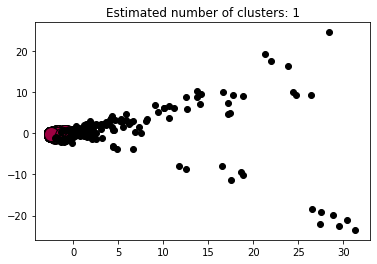

In [30]:
from sklearn.cluster import DBSCAN

features_data_std = StandardScaler().fit_transform(partner_features)
pca = PCA(n_components=10)
princ_comp = pca.fit_transform(features_data_std)
X = princ_comp[:,[0,1]]
    
# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
# print('Estimated number of noise points: %d' % n_noise_)
# print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
# print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
# print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
# print("Adjusted Rand Index: %0.3f"
#       % metrics.adjusted_rand_score(labels_true, labels))
# print("Adjusted Mutual Information: %0.3f"
#       % metrics.adjusted_mutual_info_score(labels_true, labels))
# print("Silhouette Coefficient: %0.3f"
#       % metrics.silhouette_score(X, labels))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

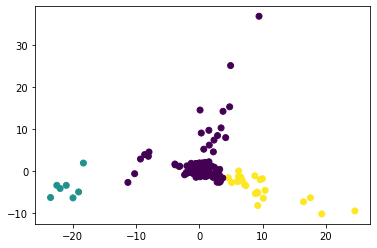

In [31]:
features_data_std = StandardScaler().fit_transform(partner_features)
pca = PCA(n_components=10)
princ_comp = pca.fit_transform(features_data_std)
X = princ_comp[:,[1,2]]

from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters=3).fit(X)
clustering.labels_
plt.scatter(X[:, 0], X[:, 1], c=clustering.labels_);

### Extra stuff

In [32]:
# cols = ['PC' + str(c+1) for c in np.arange(nPC)]
# pca_scores = pd.DataFrame(princ_comp,
#                           columns=cols,
#                           index=target,)
# pca_scores['class'] = target

# sns.lmplot(x='PC1', 
#            y='PC2', 
#            data=pca_scores, fit_reg=False, hue='class');

In [33]:
# plt.figure()
# lw = 2

# for i, target_name in zip(list(rng), target_names):
#     plt.scatter(princ_comp[y == i, 0], princ_comp[y == i, 1], 
#                 alpha=.8, lw=lw,
#                 label=target_name)
# plt.legend(loc='best', shadow=False, scatterpoints=1)
# plt.title('PCA of trade dataset');

In [34]:
# DO NOT MODIFY
def biplot_PCA_static(features_data, nPC=2, firstPC=1, secondPC=2, obs='reporter.ISO', show_loadings=False):
    """Projects the data in the 2-dimensional space spanned by 2 principal components
    chosen by the user, along with a bi-plot of the top 3 loadings per PC, and colors
    by class label.
    
    Args:
        features_data: data-set of features
        nPC: number of principal components
        firstPC: integer denoting first principal component to plot in bi-plot
        secondPC: integer denoting second principal component to plot in bi-plot
        obs: string denoting index of class labels (in features_data)
        show_loadings: Boolean indicating whether PCA loadings should be displayed
    Returns:
        plot (static)
        pca_loadings (if show_loadings=True)
    """
    
    # Run PCA (standardize beforehand)
    features_data_std = StandardScaler().fit_transform(features_data)
    pca = PCA(n_components=nPC)
    princ_comp = pca.fit_transform(features_data_std)

    # Loadings
    cols = ['PC' + str(c+1) for c in np.arange(nPC)]
    pca_loadings = pd.DataFrame(pca.components_.T, 
                                columns=cols,
                                index=list(features_data.columns))

    # Scores
    score_PC1 = princ_comp[:,firstPC-1]
    score_PC2 = princ_comp[:,secondPC-1]
    
    pca_scores = pd.DataFrame(princ_comp, 
                              columns=cols)
    
    # Return chosen PCs to plot
    PC1 = 'PC'+str(firstPC)
    PC2 = 'PC'+str(secondPC)

    # Top loadings (in absolute value)
#     toploadings_PC1 = pca_loadings.nlargest(3, PC1)
#     toploadings_PC2 = pca_loadings.nlargest(3, PC2)
    toploadings_PC1 = pca_loadings.apply(lambda x: abs(x)).sort_values(by=PC1).tail(3)
    toploadings_PC2 = pca_loadings.apply(lambda x: abs(x)).sort_values(by=PC2).tail(3)

    # Plot bi-plot
    plt.figure(figsize=(10,10))
    for i in range(toploadings_PC1.shape[0]):
        plt.arrow(0, 0, 
                  toploadings_PC1[PC1][i]*max(score_PC1)*1.5, 
                  toploadings_PC1[PC2][i]*max(score_PC2)*1.5,
                  color='r', width=0.0005, head_width=0.0025)
        plt.text(toploadings_PC1[PC1][i]*max(score_PC1)*1.5, 
                 toploadings_PC1[PC2][i]*max(score_PC2)*1.5,
                 toploadings_PC1.index.tolist()[i], color='r')
    for i in range(toploadings_PC2.shape[0]):
        plt.arrow(0, 0, 
                  toploadings_PC2[PC1][i]*max(score_PC1)*1.5, 
                  toploadings_PC2[PC2][i]*max(score_PC2)*1.5,
                  color='g', width=0.0005, head_width=0.0025)
        plt.text(toploadings_PC2[PC1][i]*max(score_PC1)*1.5, 
                 toploadings_PC2[PC2][i]*max(score_PC2)*1.5,
                 toploadings_PC2.index.tolist()[i], color='g')
        
    # Extract class labels
    target = features_data.reset_index().set_index(obs).index.tolist()
    y = pd.Series(target).astype('category').cat.codes.values
    target_names = np.unique(target)
    rng = np.arange(0, len(target_names))
    
    # Add points
    for i, target_name in zip(list(rng), target_names):
         plt.scatter(princ_comp[y == i, firstPC-1], princ_comp[y == i, secondPC-1], 
                     alpha=.5, lw=2)
    plt.xlabel('Principal Component ' + str(firstPC))
    plt.ylabel('Principal Component ' + str(secondPC))
    
    if show_loadings:
        return pca_loadings

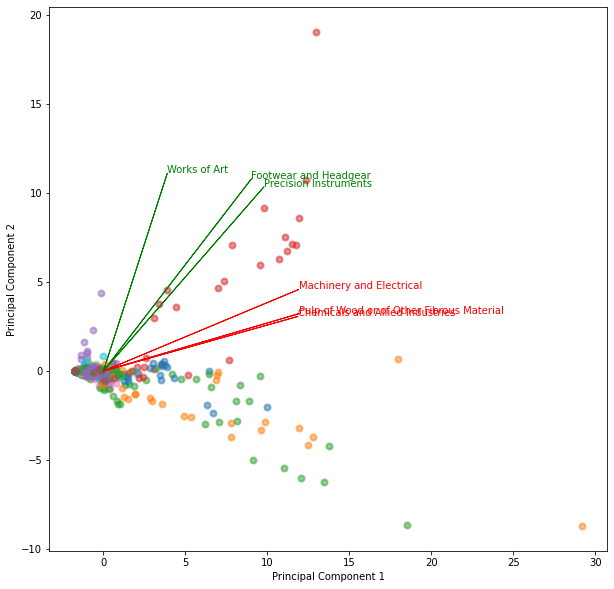

In [35]:
biplot_PCA_static(sector_features, 10, 1, 2, obs='reporter.ISO')